# ✪ Avengers Recognition with PyTorch Transfer Learning ✪

**Machine Learning Image Multiclass Classification**

---


Hi Superhero,

This notebook builds an end-to-end multiclass image classifier using PyTorch and transfer learning method. With this you will be able to recognize the Avengers superhero without knowing the whole universe.

The plan for this project is as follows:

1. Prepare our workspace
1. Check data
1. Setup data transforms and create data loader
1. Create the model using a pretrained model (ResNet50)
1. Train and evaluate the model
1. Save and load the model
1. Check the model on sample images


Alright, let's get started!

## 1. Prepare our workspace

Firstly, we need necessary packages with core libraries.

In [1]:
#!pip install matplotlib
#!pip install torchvision
#!pip install numpy

Now we can import libraries which we are going to use in this project. 

In [2]:
import os, random, time, copy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models

At the end, we check and display versions of our packages.

In [3]:
import sys
import matplotlib
import torchvision

print(f'Python: {sys.version}')
print(f'Matplotlib: {matplotlib.__version__}')
print(f'NumPy: {np.__version__}')
print(f'PyTroch: {torch.__version__}')
print(f'torchvision: {torchvision.__version__}')

Python: 3.10.6 (main, Oct 24 2022, 16:07:47) [GCC 11.2.0]
Matplotlib: 3.6.2
NumPy: 1.23.3
PyTroch: 1.13.0+cu117
torchvision: 0.14.0+cu117


## 2. Check data

Let's look at the structure of our `data` folder.


In [4]:
# Data folder path
data_path = "data"

def list_files(path):
    """
    Display the directory structure with information 
    about the number of supported image formats:
    """
    # Image formats supported by PyTorch
    supported_img_format = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', 
                            '.pgm', '.tif', '.tiff', '.webp']
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        # Print current directory with a level indent 
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        if files:            
            num_images = sum(1 for file in files 
                                   if '.' + file.split('.')[-1].lower() 
                                   in supported_img_format)
            # Print number of supported images if any
            print(f'{subindent}<<{num_images} image files>>')

list_files('data')

data/
    validation/
        captain-america/
            <<50 image files>>
        iron-man/
            <<50 image files>>
        thor/
            <<50 image files>>
        hulk/
            <<50 image files>>
    test-sample/
        <<12 image files>>
    train/
        captain-america/
            <<350 image files>>
        iron-man/
            <<350 image files>>
        thor/
            <<350 image files>>
        hulk/
            <<350 image files>>


As we can see, we have 350 test images and 50 validation images for each class.

Let's show some random image examples.

In [5]:
train_data_path = os.path.join(data_path, 'train')
validation_data_path = os.path.join(data_path, 'validation')

# Paths to individual directories 
avengers_paths = [os.path.join(train_data_path, dir) 
                  for dir in os.listdir(train_data_path)]

# Remove paths to files or empty directories
for item in list(avengers_paths):  
    if not os.path.isdir(item) or len(os.listdir(item)) == 0:
        avengers_paths.remove(item)

# List with Avengers labels
avengers_labels = [path.split('/')[-1] for path in avengers_paths]

# List with random Avengers images
random_avengers = [Image.open(os.path.join(path, random.choice(os.listdir(path)))) 
                   for path in avengers_paths]

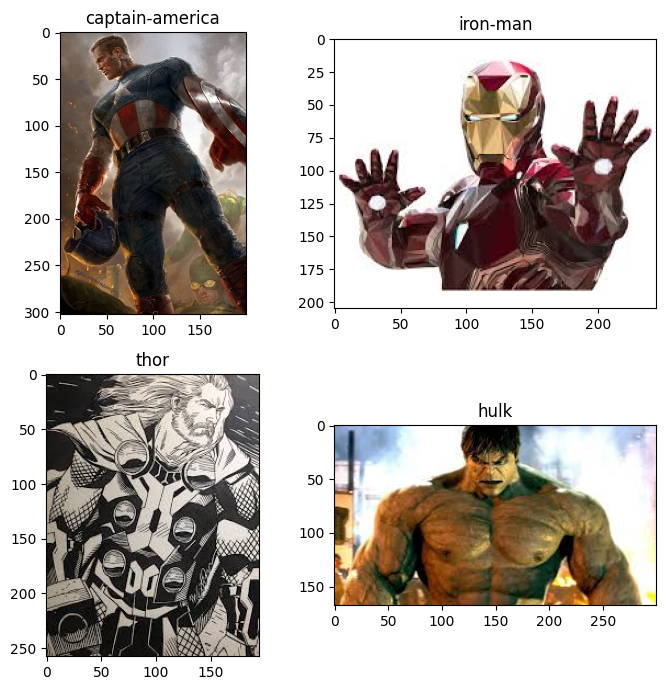

In [6]:
# Draw a representation of the Avengers (4 at the moment)
plt.figure(figsize=(7, 7))

for i in range(4):
    # Create subplots (2 rows, 2 columns)
    ax = plt.subplot(2, 2, i+1)
    # Display an image
    plt.imshow(random_avengers[i])
    # Add the image label as the title
    plt.title(avengers_labels[i])
    
# Set tight layout
plt.tight_layout(h_pad=1)

In addition, it's worth to emphasize that the data has been previously checked for the possibility of duplication or very similar pictures. This [Duplicate Image Finder (difPy)](https://github.com/elisemercury/Duplicate-Image-Finder) was used for this purpose.

Ok, as everything seems fine, let's move on.

## 3. Setup data transforms and create data loader

First, we set our data transforms, which are supposed to:
* resize images to 224x224 size,
* apply random affine transformation ([docs](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomAffine.html) and [nice shown](https://www.mathworks.com/discovery/affine-transformation.html)) - only on training data,
* apply random horizontal flip ([docs](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html)) - only on training data,
* convert images to tensors,
* normalize data (with the mean and std of the ImageNet dataset).

In [7]:
# The mean and std of ImageNet are: 
# mean = [0.485, 0.456, 0.406] 
# std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

Now we create our data loaders.

We use `datasets.ImageFolder()` method which expects our data to be organized in the following way: `root/label/image.jpg` with separate folders for training and validation data - just like we have.

In [8]:
image_datasets = {
    'train':
        datasets.ImageFolder(train_data_path, data_transforms['train']),
    'validation':
        datasets.ImageFolder(validation_data_path, data_transforms['validation'])}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True, num_workers=4),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False, num_workers=4)
}

Ok, we can move on to the most exciting parts. 🙂

## 4. Create the model using a pretrained model (ResNet50)

First, we set the device on which we can work: CUDA (if available) or CPU.

In my case, it's a good old CPU (Intel i7-4770k). However, for our purpose it turns out to be sufficient.

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We want to import a pre-trained model, freeze all its convolutional layers, and train only the last one(s).

Which model should we choose and what parameters should we set in it?

The unequivocal answer is not simple. We could test several possibilities, but we will use a proven solution and use the model and parameters proposed in the article: [Keras vs. PyTorch: Alien vs. Predator recognition with transfer learning](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning/). I highly recommend reading the entire post. However, note that we have used newer (better) weights of the ResNet50 model.

According to above, here we:
* load pre-trained network, cut off its head and freeze its weights,
* add custom dense layers (we pick 128 neurons for the hidden layer),
* set the optimizer and loss function.

In [10]:
# Load ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
    
# Freeze weights of the current layers of the loaded model
for param in model.parameters():
    param.requires_grad = False   

# Get number of parameters going in to last layer and get number of predicted classes
num_last_in = model.fc.in_features
num_classes = len(avengers_labels)

# Replace last (fully connected) layer with a self-specified ones
model.fc = nn.Sequential(
    nn.Linear(num_last_in, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, num_classes)).to(device);

# Set evaluation criterion (loss function) and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

Ok, it's time to train!

## 5. Train and evaluate the model

The most important moment is ahead of us - training the model.

The individual elements of the following function should not be complicated for a reader with basic knowledge of training a neural network. However, every important element of the function is described in comments.

In sequence, for each epoch it:
* loads the data into the model in batches (using `dataloaders`) - training and validation data separately,
* makes a predicts and calculates the loss function - for each batch and for each epoch,
* updates network weights accordingly after each batch - only in training phase,
* saves the model after the end of epoch if its weights are the best up to that moment and loads it at the end.

In [11]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Make predictions                
                outputs = model(inputs)
                
                # Calculate the loss function 
                loss = criterion(outputs, labels)                
                
                # Backward + optimize only if in training phase
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()           
                    
                # Statistics of batch
                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # Statistics of epoch
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])

            print(f'{phase} loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}')
                  
            # Deep copy the model if its weights are the best
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
        print()
    
    # Time elapsed and the best accuracy
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
        
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

So here we go:

In [12]:
model = train_model(model, criterion, optimizer, num_epochs=5)
print()

Epoch 1/5
----------
train loss: 0.6031, acc: 0.8143
validation loss: 0.2266, acc: 0.9350

Epoch 2/5
----------
train loss: 0.1848, acc: 0.9500
validation loss: 0.1496, acc: 0.9400

Epoch 3/5
----------
train loss: 0.1155, acc: 0.9671
validation loss: 0.1414, acc: 0.9500

Epoch 4/5
----------
train loss: 0.0927, acc: 0.9721
validation loss: 0.1118, acc: 0.9600

Epoch 5/5
----------
train loss: 0.0640, acc: 0.9836
validation loss: 0.1371, acc: 0.9400

Training complete in 12m 57s
Best val Acc: 0.960000



Alright, that looks pretty good. An accuracy of 96% is quite satisfactory. 

Also, I have to commend my almost 10-year-old CPU for getting the job done in a pretty reasonable amount of time. 🙂

After that we can move on to the next, final steps.

## 6. Save and load the model

Keeping the model in a saved form allows to use it in the future without (usually) time-consuming training.

**Saving**

We save the model in the [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html) by saving only its weights to the directory with the indicated path - by default, the program will compress it to a new zipfile-based file format.


In [13]:
torch.save(model.state_dict(), 'models/pytorch-resnet50.pt')

**Loading**

Before loading the weights, we need to construct the same model.

In [14]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 4)).to(device)

And now we load weights.

In [15]:
model.load_state_dict(torch.load('models/pytorch-resnet50.pt'))
model.eval();

## 7. Check the model on sample images

Alright, our fun is slowly coming to the end. 

As a summary, we check how exactly our model is doing on sample test images that it hasn't seen before.

First we need to write some code.

In [16]:
# Get labels from our train datasets
labels = list(image_datasets['train'].class_to_idx)

In [17]:
# Set path to the 'test-sample' folder with images
test_data_path = os.path.join(data_path, 'test-sample')

# Make a list with test images
images_paths = [os.path.join(test_data_path, file) 
                  for file in os.listdir(test_data_path)]
images_paths.sort()
images = [Image.open(image) for image in images_paths]

# Get image names
images_names = [image_path.split('/')[-1] for image_path in images_paths]

In [18]:
# Use the transformation used for the validation set
test_batch = torch.stack([data_transforms['validation'](image).to(device)
                          for image in images])

# Make predictions
pred_logits_tensor = model(test_batch)

# Get predicted probabilities
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

In [19]:
def plot_pred(images, images_names, pred_probs, labels, n=1):
    """
    View the image and prediction for the nth image in the image list
    """    
    # Get predicted probabilities and image for sample n
    pred_prob, image = pred_probs[n], images[n]

    # Get the predicted label
    pred_label = labels[np.argmax(pred_prob)]

    # Plot image 
    plt.imshow(image)

    # Change plot title to predicted label and probability of prediction
    plt.title(f"{pred_label} {np.max(pred_prob)*100:2.0f}%")
    plt.xlabel(images_names[n]) 

In [20]:
def plot_pred_conf(pred_probs, labels, images_names=False, n=1):
    """
    Plot predicted probabilities along with the label for sample n
    """    
    # Get predicted probabilities for sample n
    pred_prob = pred_probs[n]

    # Get the predicted label
    pred_label = labels[np.argmax(pred_prob)]

    # Find prediction confidence indexes
    pred_indexes = pred_prob.argsort()[::-1]
    
    # Find prediction confidence values
    pred_values = pred_prob[pred_indexes]
    
    # Find prediction labels
    pred_labels = np.array(labels)[pred_indexes]

    # Setup plot
    top_plot = plt.bar(np.arange(len(pred_labels)),
                     pred_values,
                     color="grey")
    plt.xticks(np.arange(len(pred_labels)),
             labels=pred_labels,
             rotation="vertical")    

    # Change color of true label if images_names allows
    if images_names:
        true_label = images_names[n].split('_')[0]
        top_plot[np.argmax(pred_labels == true_label)].set_color("green")

Alright, finally, let's check out our predictions!

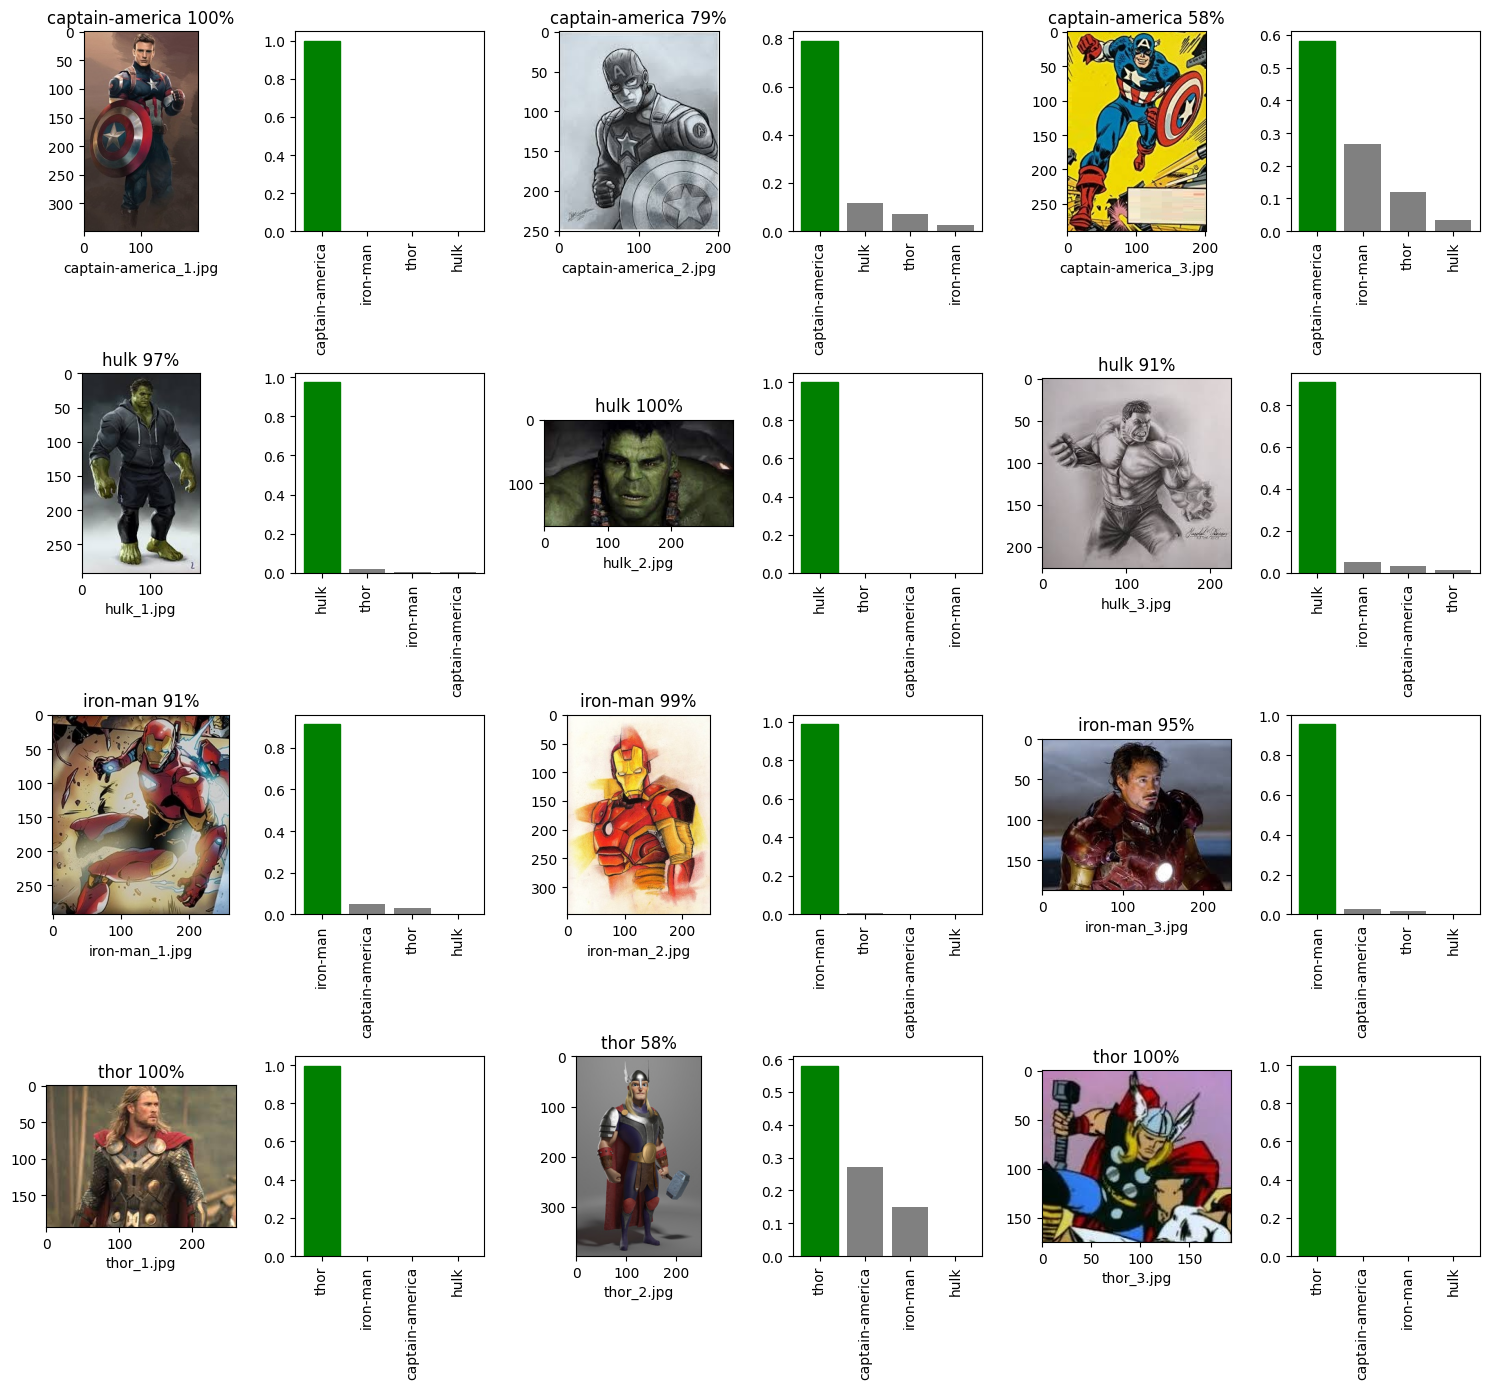

In [21]:
num_rows = 4
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(5 * num_cols, 3.5 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2*i+1)
    plot_pred(images, images_names, pred_probs, labels, i)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(pred_probs, labels, images_names, i)

plt.tight_layout(h_pad=1)
plt.show()

And that's it! Thanks for your attention, I hope you are satisfied with the results, see you next time!

Marek